In [1]:
# basic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

# modelling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# xgboost
from xgboost import XGBClassifier

# lightgbm
import lightgbm as lgb

# metrics"
from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Import data

In [2]:
train_df = pd.read_csv('train.csv', parse_dates = ['Dates'])

In [3]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
len(train_df)

878049

In [5]:
train_df.isna().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [31]:
len(train_df['Category'].unique())

39

**Given that the test data does not include the Descript or the Resolution columns, we will initially remove them to focus on the more important**

In [110]:
df = train_df.copy()
df.drop(columns=['Descript', 'Resolution'], axis=1, inplace=True)

In [112]:
df.dtypes

Dates         datetime64[ns]
Category              object
DayOfWeek             object
PdDistrict            object
Address               object
X                    float64
Y                    float64
dtype: object

# Augment data

**Break date into day, month, year, hour**

In [113]:
df['Year'] = df['Dates'].dt.year
df['Month'] = df['Dates'].dt.month
df['Day'] = df['Dates'].dt.day
df['Hour'] = df['Dates'].dt.hour
df['Dayofweek'] = df['Dates'].dt.dayofweek

In [114]:
# subtract 2000 from the year to keep data in the same range
df['Year'] = df['Year'] - 2000

In [115]:
df.drop('Dates', axis=1, inplace=True)
df.drop('DayOfWeek', axis=1, inplace=True)

### Exact address is irrelevant. Replace it by checking if it is a street or an avenue

In [117]:
def check_st_at(str_list):
    for word in str_list.split():
        if word == 'AV':
            return 'AV'
    return 'ST'

In [118]:
df['Roadtype'] = df.apply(lambda row: check_st_at(row.Address), axis=1)

In [119]:
# we can now drop Address
df.drop('Address', axis=1, inplace=True)

### Normalize coordinates

In [121]:
scaler_X = preprocessing.MinMaxScaler()
scaler_Y = preprocessing.MinMaxScaler()

X_def, Y_def = df['X'].values, df['Y'].values #returns a numpy array
X_scaled = scaler_X.fit_transform(X_def.reshape([-1,1]))
Y_scaled = scaler_Y.fit_transform(Y_def.reshape([-1,1]))

df['X'] = X_scaled
df['Y'] = Y_scaled

In [129]:
### Save pre-processed df to csv
df.to_csv('preprocessed_data.csv', index=False)

# EDA

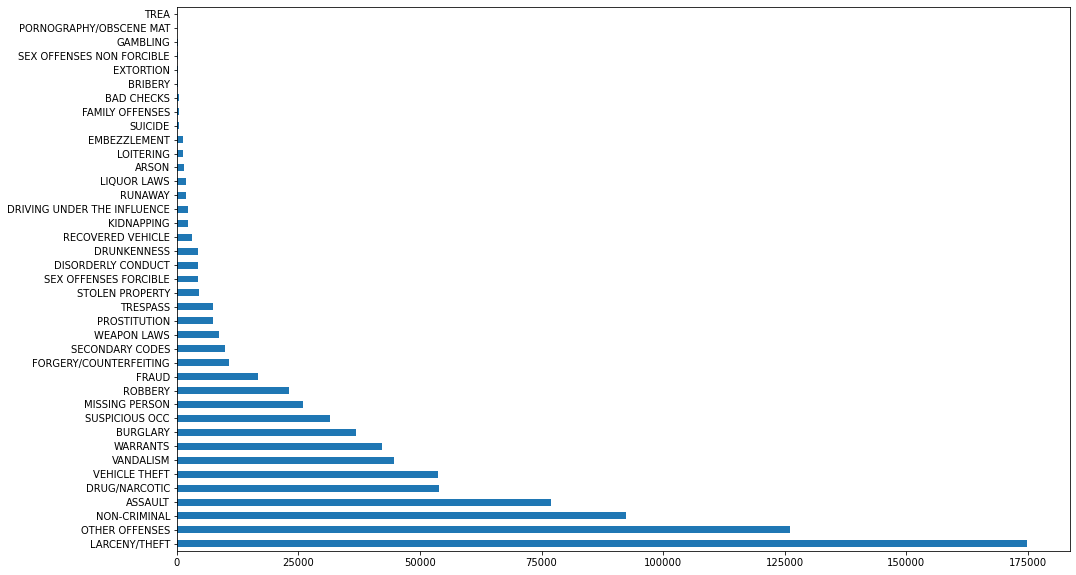

In [153]:
df['Category'].value_counts().plot(kind='barh', figsize=(16,10));

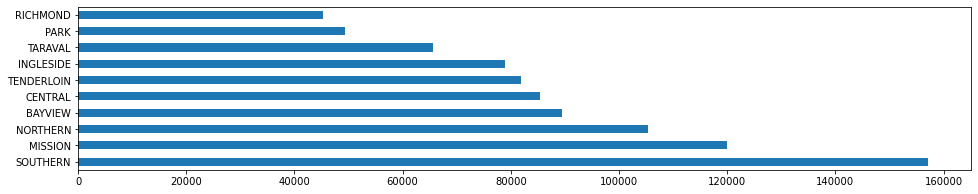

In [159]:
df['PdDistrict'].value_counts().plot(kind='barh', figsize=(16,3));

[Text(0.5, 0, 'X'), Text(0, 0.5, 'Y')]

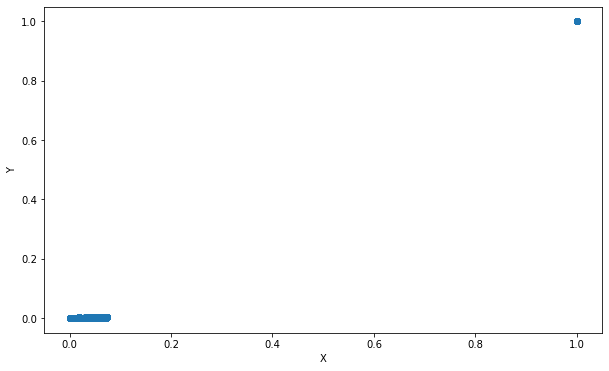

In [163]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(df['X'], df['Y']);
ax.set(xlabel='X',
       ylabel='Y');

In [166]:
# lets look for outliers
to_drop = df[(df['X'] > 0.9)|(df['Y'] > 0.9)].index
to_drop

Int64Index([660485, 660711, 660712, 661106, 666430, 667042, 669946, 671709,
            673078, 673114, 673115, 673510, 674043, 675070, 675073, 675288,
            675540, 677036, 677260, 677268, 677828, 678326, 678539, 678540,
            679643, 682780, 683862, 684406, 685719, 685720, 686997, 687519,
            687527, 688950, 692258, 712309, 719993, 727080, 754828, 756059,
            759292, 759397, 767318, 767501, 767502, 772415, 772431, 773159,
            783919, 788574, 788575, 789255, 798834, 823378, 833362, 833921,
            839585, 842259, 842261, 842434, 842435, 842828, 844995, 845842,
            852880, 857248, 871198],
           dtype='int64')

In [167]:
# drop outliers since they are only 67 and rescale
df.drop(to_drop, inplace=True)

In [168]:
scaler_X = preprocessing.MinMaxScaler()
scaler_Y = preprocessing.MinMaxScaler()

X_def, Y_def = df['X'].values, df['Y'].values #returns a numpy array
X_scaled = scaler_X.fit_transform(X_def.reshape([-1,1]))
Y_scaled = scaler_Y.fit_transform(Y_def.reshape([-1,1]))

df['X'] = X_scaled
df['Y'] = Y_scaled

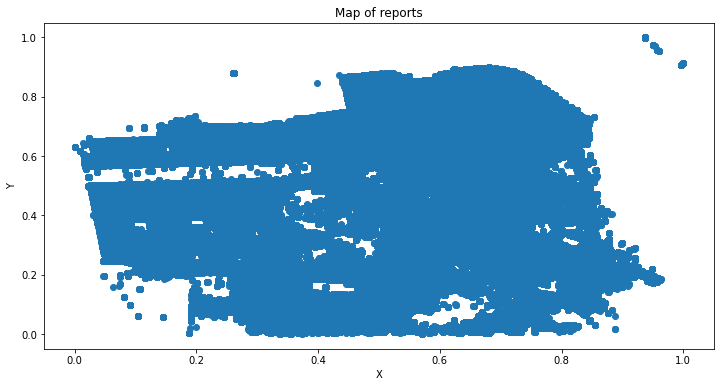

In [172]:
fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(df['X'], df['Y']);
ax.set(xlabel='X',
       ylabel='Y',
       title='Map of reports');

In [173]:
### Save pre-processed df to csv
df.to_csv('preprocessed_data_dropped.csv', index=False)

## Distribution of reports over the year, months, days, hours

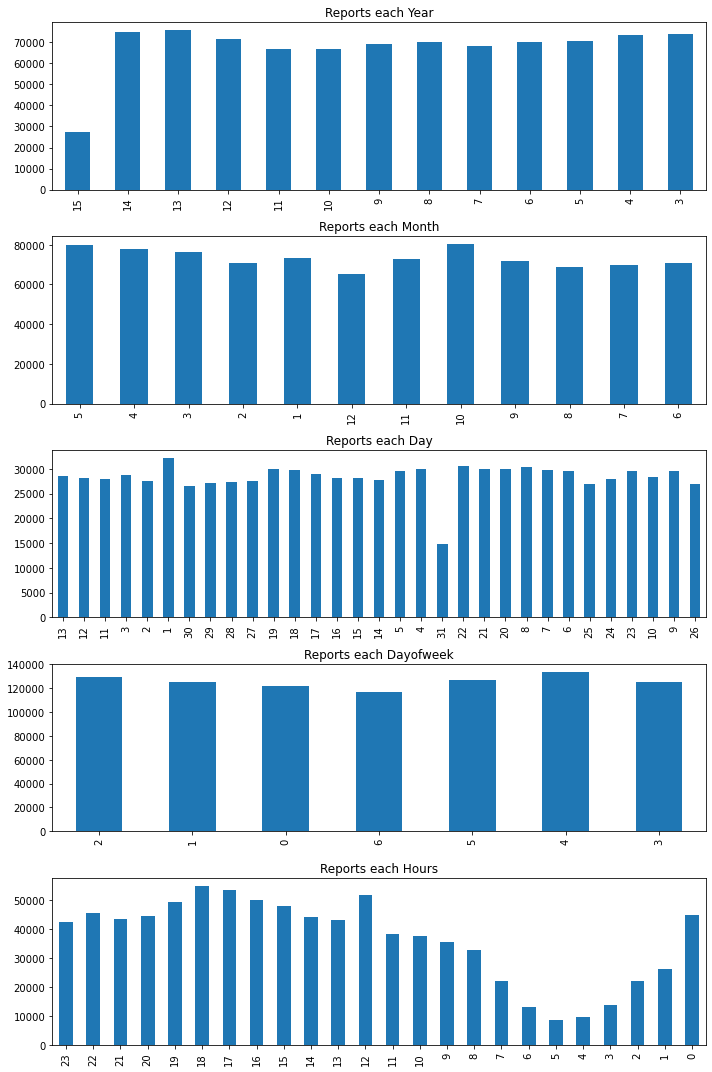

In [195]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5, figsize=(10,15))

df['Year'].value_counts(sort=False).plot(kind='bar', ax=ax0)
df['Month'].value_counts(sort=False).plot(kind='bar', ax=ax1)
df['Day'].value_counts(sort=False).plot(kind='bar', ax=ax2)
df['Dayofweek'].value_counts(sort=False).plot(kind='bar', ax=ax3)
df['Hour'].value_counts(sort=False).plot(kind='bar', ax=ax4)

ax0.set(title='Reports each Year')
ax1.set(title='Reports each Month')
ax2.set(title='Reports each Day')
ax3.set(title='Reports each Dayofweek')
ax4.set(title='Reports each Hours')

plt.tight_layout()

## Distribution of PDs

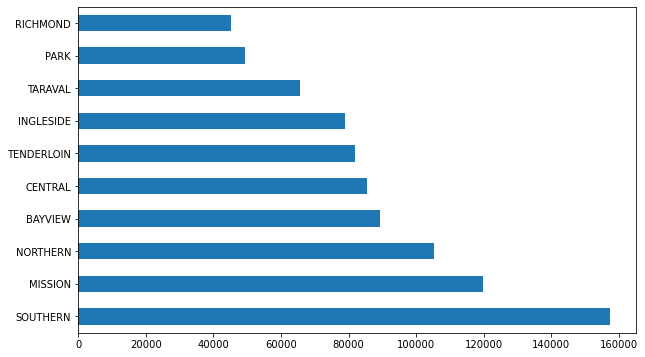

In [186]:
df['PdDistrict'].value_counts().plot(kind='barh', figsize=(10,6));

## Distribution over Roadtype

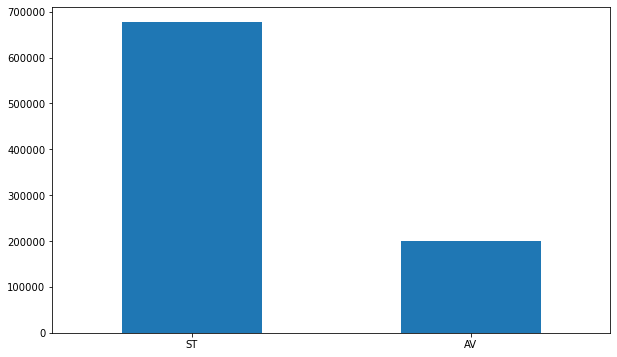

In [191]:
df['Roadtype'].value_counts().plot(kind='bar', figsize=(10,6));
plt.xticks(rotation='horizontal');

## Check the correlation between Minutes and Felony
For each minute, extract the top 3 most likely charges

In [94]:
sum_each_minute = df.groupby('Minute')['X'].count()

In [95]:
s = df.groupby(["Minute", 'Category'], as_index=False)['X'].count()

In [96]:
s = s.groupby(['Minute']).apply(lambda x: x.sort_values(['X'],ascending = False)).reset_index(drop = True)

In [105]:
top3_each_minute = s.groupby(['Minute']).head(3).rename(columns={'X':'count'}).set_index('Minute')

In [106]:
top3_each_minute

,Category,count
Minute,,
0,LARCENY/THEFT,76622
0,NON-CRIMINAL,31432
0,VEHICLE THEFT,30380
1,LARCENY/THEFT,4726
1,OTHER OFFENSES,3681
...,...,...
58,DRUG/NARCOTIC,664
58,NON-CRIMINAL,495
59,OTHER OFFENSES,900


In [113]:
sum_each_minute

Minute
0     268930
1      25859
2       4403
3       4624
4       4701
5      15764
6       4654
7       4658
8       5026
9       4422
10     22761
11      4550
12      5019
13      4629
14      4829
15     37900
16      4408
17      4787
18      5242
19      4529
20     26025
21      4284
22      4996
23      4903
24      4764
25     16176
26      4401
27      4726
28      4875
29      4392
30    125165
31      4120
32      4493
33      4737
34      4516
35     15549
36      4463
37      4807
38      4946
39      4522
40     24668
41      4383
42      4811
43      4599
44      4704
45     40227
46      4377
47      4620
48      5059
49      4341
50     25495
51      4308
52      4570
53      4748
54      4618
55     15406
56      4437
57      4637
58      4850
59      4569
Name: X, dtype: int64

**Based on evidence, the minutes in highly probable to be either 0, 15, 30, or 45. As such, we will discard minute**

# Create a data preprocessing function

In [4]:
def check_st_at(str_list):
    for word in str_list.split():
        if word == 'AV':
            return 'AV'
    return 'ST'

In [5]:
def preprocess_df(df_in, is_train = True):
    
    df = df_in.copy()
    
    if is_train: 
        df.drop(columns=['Descript', 'Resolution'], axis=1, inplace=True)
    df['Year'] = df['Dates'].dt.year
    df['Month'] = df['Dates'].dt.month
    df['Day'] = df['Dates'].dt.day
    df['Hour'] = df['Dates'].dt.hour
    df['Minute'] = df['Dates'].dt.minute
    df['Dayofweek'] = df['Dates'].dt.dayofweek
    
    df.drop('Dates', axis=1, inplace=True)
    df.drop('DayOfWeek', axis=1, inplace=True)
    
    # subtract 2000 from the year to keep data in the same range
    df['Year'] = df['Year'] - 2000
    
    df['Roadtype'] = df.apply(lambda row: check_st_at(row.Address), axis=1)
    df['Block'] = df['Address'].str.contains('block', case=False).apply(lambda x: 1 if x == True else 0)
    # we can now drop Address
    df.drop('Address', axis=1, inplace=True)
    
    # Drop outliers
    to_drop = df[(df['X'] == -120.5)|(df['Y'] == 90)].index
    if is_train:
        df.drop(to_drop, inplace=True)
    
    scaler_X = preprocessing.MinMaxScaler()
    scaler_Y = preprocessing.MinMaxScaler()
    scaler_XY = preprocessing.MinMaxScaler()
    scaler_sum = preprocessing.MinMaxScaler()
    scaler_diff = preprocessing.MinMaxScaler()
    scaler_prod = preprocessing.MinMaxScaler()

    X_def, Y_def = df['X'].values, df['Y'].values #returns a numpy array
    XY_sq = X_def**2 + Y_def**2
    XYsum = X_def + Y_def
    XYdiff = X_def - Y_def
    XYprod = np.multiply(X_def, Y_def)
    
    X_scaled = scaler_X.fit_transform(X_def.reshape([-1,1]))
    Y_scaled = scaler_Y.fit_transform(Y_def.reshape([-1,1]))
    XY_sq_scaled = scaler_XY.fit_transform(XY_sq.reshape([-1,1]))
    XY_sum_scaled = scaler_sum.fit_transform(XYsum.reshape([-1,1]))
    XY_diff_scaled = scaler_diff.fit_transform(XYdiff.reshape([-1,1]))
    XY_prod_scaled = scaler_prod.fit_transform(XYprod.reshape([-1,1]))

    df['X'] = X_scaled
    df['Y'] = Y_scaled
    df['XYsq'] = XY_sq_scaled
    df['XYsum'] = XY_sum_scaled
    df['XYdiff'] = XY_diff_scaled
    df['XYprod'] = XY_prod_scaled
    
    #encode categorical columns
    if is_train:
        df['Category'] = df['Category'].astype('category')
    df['PdDistrict'] = df['PdDistrict'].astype('category')b
    df['Roadtype'] = df['Roadtype'].astype('category')
    
    df_cat = df.copy()
    
    if is_train:
        df_cat['Category'] = df_cat['Category'].cat.codes
    df_cat['PdDistrict'] = df_cat['PdDistrict'].cat.codes
    df_cat['Roadtype'] = df_cat['Roadtype'].cat.codes
    
    return df_cat, df

# Model

## Load and prepare data

In [6]:
train_df = pd.read_csv('train.csv', parse_dates = ['Dates'], low_memory=False)

df_cat2, df2 = preprocess_df(train_df)

In [7]:
X = df_cat2.drop(columns= ['Category'])
y = df_cat2['Category']

## KNN

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [42]:
knn = KNeighborsClassifier(n_neighbors=100)

In [43]:
%%time
knn.fit(X_train, y_train)

Wall time: 34.8 s


KNeighborsClassifier(n_neighbors=100)

In [44]:
y_probs_train = knn.predict_proba(X_train)
y_probs_val = knn.predict_proba(X_test)

print(log_loss(y_train, y_probs_train))
print(log_loss(y_test, y_probs_val))

2.356131881691766
3.933750913077195


## Logistic Regression

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [93]:
logreg = LogisticRegression(n_jobs=-1, C=1000,
                           solver='saga', penalty='elasticnet',
                           l1_ratio=0.5)

In [95]:
logreg.fit(X_train, y_train)

D:\MachineLearning\MyProjects\SanFranciscoCrimes\env\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(C=1000, l1_ratio=0.5, n_jobs=-1, penalty='elasticnet',
                   solver='saga')

In [96]:
y_probs_train = logreg.predict_proba(X_train)
y_probs_val = logreg.predict_proba(X_test)

print(log_loss(y_train, y_probs_train))
print(log_loss(y_test, y_probs_val))

2.5391372261544785
2.537733936411284


## Random Forest

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [9]:
rfc = RandomForestClassifier(n_jobs=-1, min_samples_split=50, min_samples_leaf=20,
                            n_estimators = 80)

In [23]:
rfc.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=20, min_samples_split=50,
                       n_estimators=80, n_jobs=-1)

In [24]:
y_probs_train = rfc.predict_proba(X_train)
y_probs_val = rfc.predict_proba(X_test)

print(log_loss(y_train, y_probs_train))
print(log_loss(y_test, y_probs_val))

1.9195065945209078
2.300256524634753


In [16]:
cv_res = cross_val_score(rfc, X, y, scoring='neg_log_loss',
               cv = 3)
print(cv_res)

[-3.42904581 -2.54988311 -5.50494495]


## LightGBM

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [31]:
lgbc = lgb.LGBMClassifier(objective='multiclass', num_classes=39)

In [32]:
%%time
lgbc.fit(X_train, y_train)

Wall time: 1min 5s


LGBMClassifier(num_classes=39, objective='multiclass')

In [33]:
y_probs_train = lgbc.predict_proba(X_train)
y_probs_val = lgbc.predict_proba(X_test)

print(log_loss(y_train, y_probs_train))
print(log_loss(y_test, y_probs_val))

6.492721136931207
6.862838997961302
